# Santa Claus Rally

In [1]:
import datetime as dt
import pandas as pd
import yfinance as yf

import available as avb
import utils as self_utils
from quantified_strategies import utils

C:\Users\tomw1\AppData\Local\Temp\ipykernel_20076\3432745344.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Rules
1. Buy on the first Friday after the 14th calendar day in December (OPEX Day).
2. Sell on the third trading day of the New Year.

In [2]:
BUY_DAY = 4
BUY_AFTER_CALENDAR_DAY = 14
BUY_IN_MONTH = 12

SELL_ON_NTH_DAY_IN_NEW_YEAR = 5

In [3]:
TICKER = "SPY"

In [4]:
data = utils.get_data(ticker=TICKER, columns="Adj Close").to_frame(name=TICKER)
data.head(5)

,SPY
Date,
1993-01-29,24.840679
1993-02-01,25.017365
1993-02-02,25.070358
1993-02-03,25.335369
1993-02-04,25.441376


In [5]:
data["year_month"] = data.index.map(lambda date: float(dt.datetime.strftime(date, "%Y.%m")))
data["year"] = data.index.year

### Get exit trading day

In [6]:
first_n_days_of_year = data.groupby("year").head(SELL_ON_NTH_DAY_IN_NEW_YEAR)
nth_day_of_year = first_n_days_of_year.groupby("year").tail(1)
nth_day_of_year.index = nth_day_of_year.index.year
nth_day_of_year = nth_day_of_year[TICKER].to_frame(name="exit")
nth_day_of_year.head(5)

,exit
Date,
1993,25.441376
1994,27.257635
1995,27.427502
1996,37.636238
1997,46.370945


### Get enter trading day of each month

In [7]:
first_xday_after_xdate_in_xmonth = data.loc[
    (data.index.month == BUY_IN_MONTH) & (data.index.day >= BUY_AFTER_CALENDAR_DAY) & (data.index.dayofweek == BUY_DAY)
].groupby("year_month").first()[TICKER]
first_xday_after_xdate_in_xmonth = first_xday_after_xdate_in_xmonth.to_frame(name="enter")
first_xday_after_xdate_in_xmonth.index = first_xday_after_xdate_in_xmonth.index.astype(int)
first_xday_after_xdate_in_xmonth.index.name = "Date"
first_xday_after_xdate_in_xmonth_shifted = first_xday_after_xdate_in_xmonth.shift(1)
first_xday_after_xdate_in_xmonth_shifted.head(5)

,enter
Date,
1993,NaN
1994,26.985985
1995,27.222948
1996,37.626728
1997,46.467949


### Join Data

In [8]:
df = pd.concat([first_xday_after_xdate_in_xmonth_shifted, nth_day_of_year], axis=1)
df = df.dropna()
df.index = df.index.map(lambda year: dt.datetime.strptime(str(year), "%Y"))
df = df.sort_index()
df.tail(5)

,enter,exit
Date,,
2019-01-01,238.646744,236.630585
2020-01-01,301.170929,304.664124
2021-01-01,353.140167,364.695343
2022-01-01,445.753632,451.782654
2023-01-01,377.532013,382.053284


### Calculate Returns

In [9]:
df["strat_ret"] = df["exit"] / df["enter"] - 1
df["cum_strat_ret"] = utils.get_cumulative_return(returns=df["strat_ret"], total=False)
df.head(5)

,enter,exit,strat_ret,cum_strat_ret
Date,,,,
1994-01-01,26.985985,27.257635,0.010066,0.010066
1995-01-01,27.222948,27.427502,0.007514,0.017656
1996-01-01,37.626728,37.636238,0.000253,0.017913
1997-01-01,46.467949,46.370945,-0.002088,0.015788
1998-01-01,59.756256,60.288204,0.008902,0.024831


### Plot Strategy Returns

In [14]:
import matplotlib.pyplot as plt

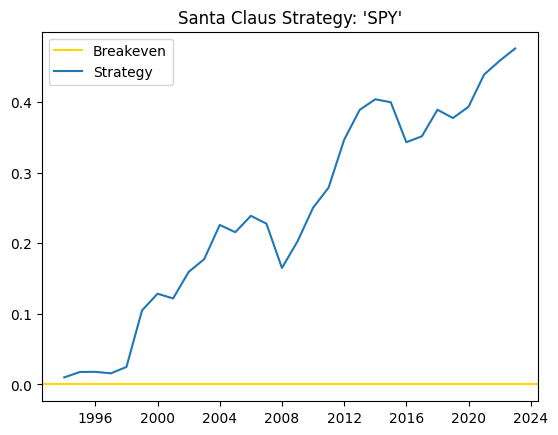

In [15]:
fig, ax = plt.subplots()

ax.axhline(y=0, label="Breakeven", color="gold")

ax.plot(df["cum_strat_ret"], label="Strategy")

plt.title(f"Santa Claus Strategy: {TICKER!r}")
plt.legend(loc="best")
plt.show()

### Describe Strategy

In [16]:
utils.describe(returns=df["strat_ret"], daily=False, asset=TICKER)

Asset                            SPY
Start                     1994-01-01
End                       2023-01-01
Mean Return                 1.33669%
Total Return                  47.58%
Median Return               1.17873%
1st Quartile               -0.20876%
3rd Quartile                3.15432%
Std Dev Return              2.54332%
CAGR                     130.573 bps
Trade CAGR                       N/A
Ann. CAGR                        N/A
Activity Ratio               100.00%
Number of Trades                 0.0
Average Hold Period       30.00 Days
Daily Sharpe Ratio            0.5256
Ann. Sharpe Ratio             8.3431
Daily Sortino Ratio           0.7128
Ann. Sortino Ratio           11.3153
Daily Calmar Ratio            7.9852
Hit Ratio                     73.33%
Profit Factor                  4.12x
MDD                           -5.96%
MDD Start                 2006-01-01
MDD Bottom                2008-01-01
MDD End                   2010-01-01
MDD Decline Duration          3 Days
M

In [70]:
df

,enter,exit,strat_ret,cum_strat_ret
Date,,,,
1994-01-01,26.985979,27.257647,0.010067,0.010067
1995-01-01,27.222958,27.427500,0.007514,0.017656
1996-01-01,37.626732,37.636250,0.000253,0.017914
1997-01-01,46.467999,46.370945,-0.002089,0.015788
1998-01-01,59.756226,60.288181,0.008902,0.024830
1999-01-01,75.679230,81.586655,0.078059,0.104827
2000-01-01,92.106766,94.083656,0.021463,0.128540
2001-01-01,85.431267,84.921654,-0.005965,0.121808
2002-01-01,74.482536,76.978310,0.033508,0.159398
